In [ ]:
import sys
import os
import re
import urllib.request
import json
import datetime
import numpy as np
import pandas as pd
import configparser
import argparse
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
train_path = "~/datasets/command.csv"
test_path = "~/datasets/test.csv"

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
def loaddata(path):
  X=[]
  Y=[]
  myFile = np.genfromtxt(path, delimiter=',', skip_header=1)
  for i in range(sum(1 for row in myFile)):
    n=0
    arr =[]
    for j in range(50):
      if myFile[i][j]==1: n+=1
    for j in range(51):
      if j != 50:
        arr.append(myFile[i][j])
      else:
        Y.append(myFile[i][j])
    X.append(arr)


  X = np.array(X, dtype = 'int32')
  Y = np.array(Y, dtype = 'int32')
  return X,Y
x_train,y_train = loaddata(train_path)
x_test,y_test = loaddata(test_path)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
x_train, y_train = shuffle(x_train, y_train, random_state=100)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))

1109
1109
59
59
44
44


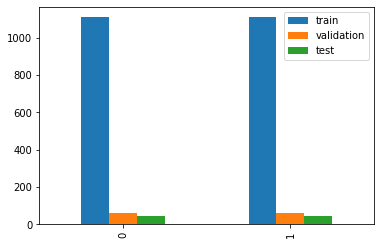

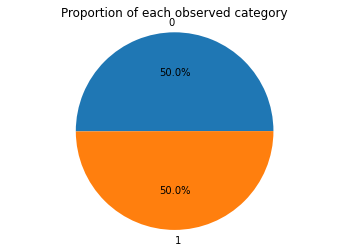

In [ ]:
import matplotlib.pyplot as plt
_, train_counts = np.unique(y_train, return_counts = True)
_, val_counts = np.unique(y_val, return_counts = True)
_, test_counts = np.unique(y_test, return_counts = True)

# pd.DataFrame({'train': train_counts, "validation": val_counts, "test": test_counts}, index = ['0','1']).plot.bar()
pd.DataFrame({'train': len(y_train), "validation": len(y_val), "test": len(y_test)}, index = ['0','1']).plot.bar()
plt.show()

plt.pie(train_counts,
        explode=(0, 0) , 
        labels=['0','1'],
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Embedding, LSTM, RNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

modelMLP = Sequential()
modelMLP.add(InputLayer(input_shape=(50,)))
modelMLP.add(Dropout(0.25))
modelMLP.add(Embedding(len(x_train), 32, input_length=50))
modelMLP.add(Dense(units = 32,kernel_regularizer=l2(0.35), bias_regularizer=l2(0.35)))
modelMLP.add(Conv1D(32,5,padding='valid',activation='relu',strides=1))
modelMLP.add(MaxPooling1D(pool_size=4))
modelMLP.add(LSTM(32))
# kernel_initializer = 'normal', activation = 'relu',
# modelMLP.add(Dropout(0.9))
# modelMLP.add(Dropout(0.2))
modelMLP.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))
modelMLP.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_48 (Dropout)         (None, 50)                0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 50, 32)            35488     
_________________________________________________________________
dense_85 (Dense)             (None, 50, 32)            1056      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 46, 32)            5152      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 11, 32)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_86 (Dense)             (None, 1)               

In [ ]:
optimizer = Adam()
modelMLP.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# callback1 = ModelCheckpoint(filepath='', 
#                             save_best_only=True, save_weights_only=True,
#                             monitor='val_accuracy',mode='max',verbose=1)
callback2 = EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=5, verbose = 1, mode='max', restore_best_weights = True)
callback3 = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    # mode = 'max',
    patience = 1, 
    verbose = 1, 
    factor = 0.1, 
    min_lr = 0.001)
historyMLP = modelMLP.fit(x_train, y_train,
                   epochs = EPOCHS,
                   batch_size = BATCH_SIZE,
                   validation_data=(x_val, y_val),
                   callbacks = callback3)                   

Epoch 1/50
18/18 [==============================] - 3s 48ms/step - loss: 11.3547 - accuracy: 0.5996 - val_loss: 10.3408 - val_accuracy: 0.6949
Epoch 2/50
18/18 [==============================] - 0s 17ms/step - loss: 9.5667 - accuracy: 0.7277 - val_loss: 8.6682 - val_accuracy: 0.5593
Epoch 3/50
18/18 [==============================] - 0s 16ms/step - loss: 7.9312 - accuracy: 0.7899 - val_loss: 7.1306 - val_accuracy: 0.8814
Epoch 4/50
18/18 [==============================] - 0s 17ms/step - loss: 6.5587 - accuracy: 0.8251 - val_loss: 5.9581 - val_accuracy: 0.8644
Epoch 5/50
18/18 [==============================] - 0s 17ms/step - loss: 5.4475 - accuracy: 0.8431 - val_loss: 4.9490 - val_accuracy: 0.8475
Epoch 6/50
18/18 [==============================] - 0s 17ms/step - loss: 4.5231 - accuracy: 0.8449 - val_loss: 4.1157 - val_accuracy: 0.8475
Epoch 7/50
18/18 [==============================] - 0s 17ms/step - loss: 3.7506 - accuracy: 0.8584 - val_loss: 3.4113 - val_accuracy: 0.8475
Epoch 8/50


In [ ]:
predictions = modelMLP.predict_classes(x_val,verbose=0) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
for i in range(len(y_test)):
	print('=> %d (expected %d)' % (predictions[i], y_val[i]))

=> 1 (expected 1)
=> 1 (expected 0)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 0)
=> 1 (expected 1)
=> 1 (expected 0)
=> 1 (expected 1)
=> 1 (expected 1)
=> 0 (expected 0)
=> 1 (expected 1)
=> 1 (expected 1)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 1 (expected 1)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 1)
=> 1 (expected 1)
=> 1 (expected 1)
=> 1 (expected 1)
=> 0 (expected 0)
=> 0 (expected 0)
=> 0 (expected 0)
=> 1 (expected 0)
=> 0 (expected 0)
=> 0 (expected 0)


In [ ]:
modelMLP.evaluate(x_val, y_val)

2/2 [==============================] - 0s 8ms/step - loss: 0.2812 - accuracy: 0.8983


[0.2811780273914337, 0.8983050584793091]

In [ ]:
modelMLP.save("NNLSTM.h5")

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

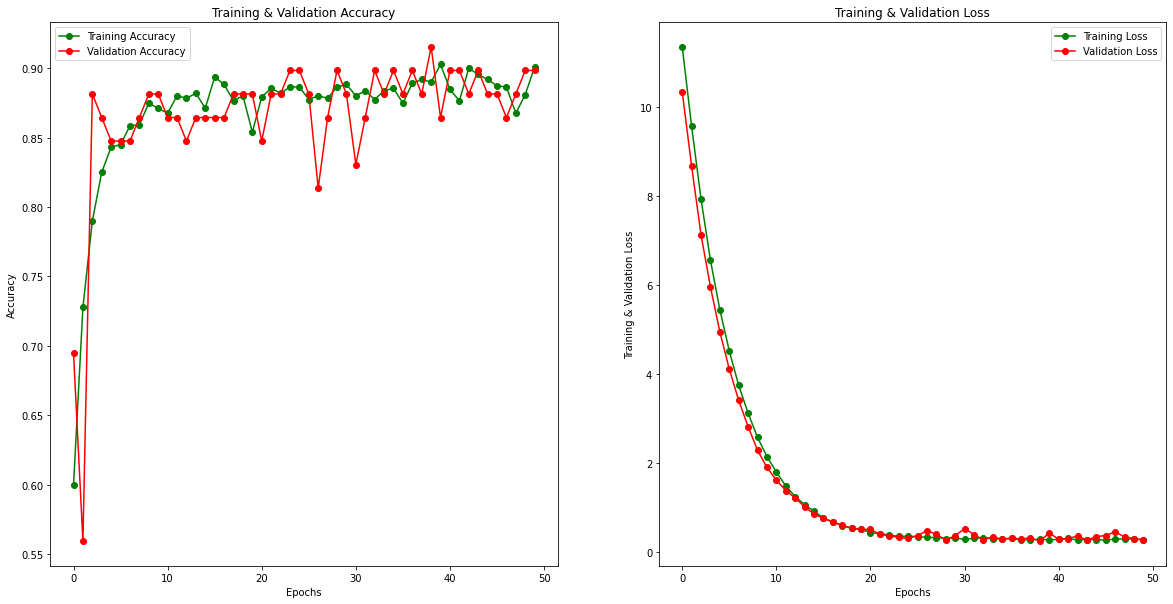

In [ ]:
plot_accuracy_loss_chart(historyMLP)

In [ ]:

from sklearn.metrics import classification_report


from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(y_val, predictions)
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])
cm

,0,1
0,29,6
1,0,24


In [ ]:
print(classification_report(
    y_val, 
    predictions, 
    target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        35
           1       0.80      1.00      0.89        24

    accuracy                           0.90        59
   macro avg       0.90      0.91      0.90        59
weighted avg       0.92      0.90      0.90        59



In [ ]:
# model_predictions_MLP = modelMLP.predict_proba(x_test)
# model_roc_score_MLP = roc_auc_score(y_test, 
#                                 model_predictions_MLP)
# model_roc_score_MLP

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('NNLSTM.h5')

print(pd.DataFrame(confusion_matrix(y_test, model.predict_classes(x_test)), 
                   index = ['0', '1'], 
                   columns = ['0', '1']))

print(classification_report(y_test, 
                            model.predict_classes(x_test),
                            target_names = ['0', '1']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


   0   1
0  0   0
1  4  40
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.91      0.95        44

    accuracy                           0.91        44
   macro avg       0.50      0.45      0.48        44
weighted avg       1.00      0.91      0.95        44



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
